In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [3]:
df = pd.read_csv('train.csv', index_col='num_id')
df.head()

,y1,y2,y3
num_id,,,
1,879878.00,52548712.45,1145963
2,892771.77,52977763.18,1029008
3,1234170.67,62610108.35,1195365
4,1424293.50,58400221.28,1370666
5,1615346.95,65722728.55,1685763


In [4]:
month_list = []
for i in range(114):
    temp = (i % 12) + 1
    month_list.append(temp)
    
df['month'] = month_list

In [5]:
year_list = np.arange(2014, 2024)

for i in range(10):
    start = (i * 12) + 1
    stop = ((i + 1) *12) + 1
    df.loc[start:stop , 'year'] = year_list[i]
    
df['year'] = df['year'].astype('int')
df.reset_index(inplace=True, drop=True)
df.head()

,y1,y2,y3,month,year
0,879878.00,52548712.45,1145963,1,2014
1,892771.77,52977763.18,1029008,2,2014
2,1234170.67,62610108.35,1195365,3,2014
3,1424293.50,58400221.28,1370666,4,2014
4,1615346.95,65722728.55,1685763,5,2014


In [6]:
temp = pd.read_csv('exogeneous/temp_cleaned.csv', index_col=0)
temp.head(12)

,Year,Month,Value
0,2014,1,22.400000
1,2014,2,26.733333
2,2014,3,29.500000
3,2014,4,30.333333
4,2014,5,29.900000
5,2014,6,29.266667
6,2014,7,28.400000
7,2014,8,27.833333
8,2014,9,27.800000
9,2014,10,27.533333


In [7]:
df = pd.concat([df, temp[:114]['Value']], axis=1)
df.sample(10)

,y1,y2,y3,month,year,Value
0,879878.00,52548712.45,1145963,1,2014,22.400000
60,743126.16,61895630.80,1367299,1,2019,26.666667
112,1489796.99,65864569.09,2612477,5,2023,28.600000
28,1794381.84,63145363.88,1977006,5,2016,30.800000
74,1238813.43,66940679.01,1483769,3,2020,29.933333
33,959276.54,63856702.59,1598120,10,2016,28.066667
113,1251936.23,64711502.54,2256003,6,2023,26.800000
36,799936.75,58521724.14,1285932,1,2017,26.566667
54,1013520.25,71334142.94,1672655,7,2018,27.833333
88,1570205.24,70292807.82,2263552,5,2021,29.900000


### Overview 
- Monthly data from Jan 2013 to June 2023
- data collected from 3 station of electricity factory in Chiang Mai

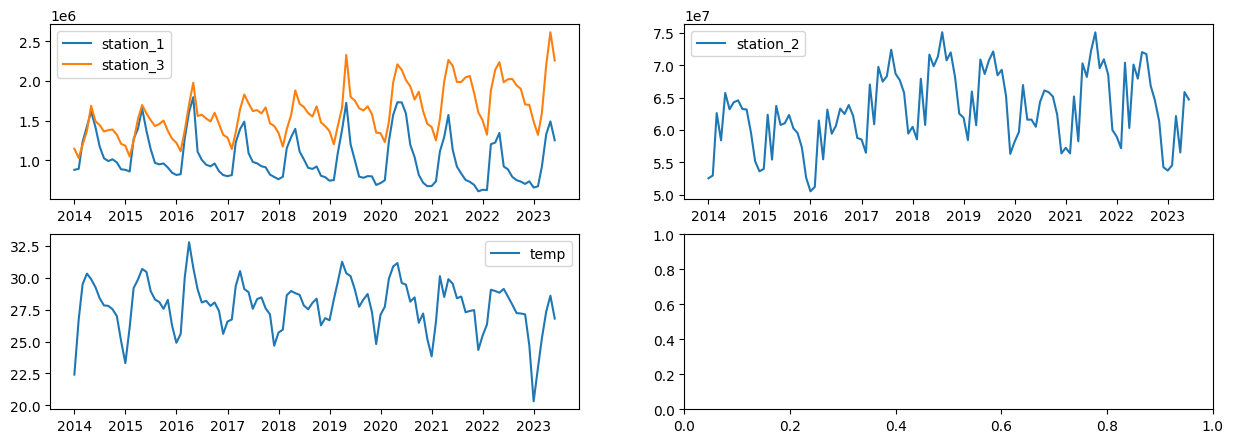

In [16]:
date = pd.to_datetime(df['year'].astype('str') + '/' + df['month'].astype('str'), format='%Y/%m')

fig, ax = plt.subplots(2, 2, figsize=(15, 5))
ax[0, 0].plot(date, df['y1'], label='station_1')
ax[0, 0].plot(date, df['y3'], label='station_3')
ax[0, 0].legend()

ax[0, 1].plot(date, df['y2'], label='station_2')
ax[0, 1].legend()

ax[1, 0].plot(date, df['Value'], label='temp')
ax[1, 0].legend()

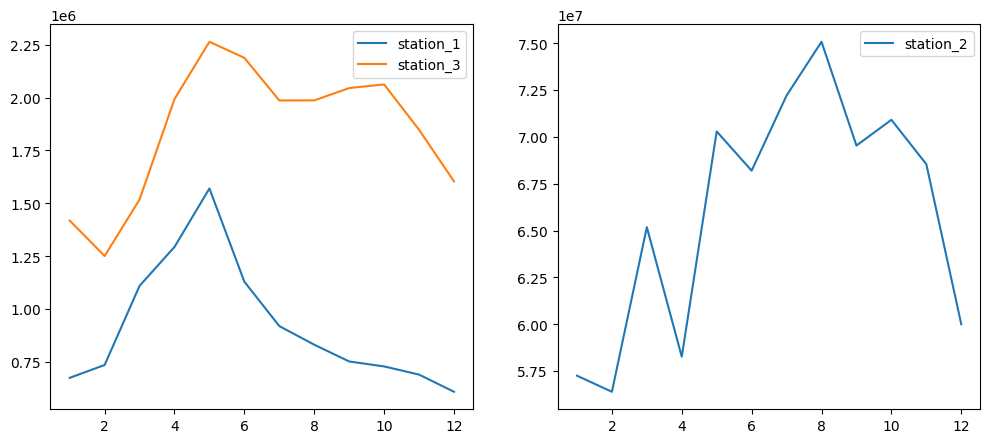

In [17]:
filter = df[ df.year == 2021 ]

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(np.arange(1, 13), filter['y1'], label='station_1')
ax[0].plot(np.arange(1, 13), filter['y3'], label='station_3')
ax[0].legend()

ax[1].plot(np.arange(1,13), filter['y2'], label='station_2')
ax[1].legend()

Note: yearly seasonal

### Feature Engineering

In [18]:
month_dump = pd.get_dummies(df['month'], prefix='month', drop_first=True).astype('int').reset_index(drop=True)
# year_dump = pd.get_dummies(df['year'], drop_first=True).astype('int')

df_prep = pd.concat([df, month_dump], axis=1)
df_prep['year'] = df_prep['year'] - 2013
df_prep.head()

,y1,y2,y3,month,year,Value,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,879878.00,52548712.45,1145963,1,1,22.400000,0,0,0,0,0,0,0,0,0,0,0
1,892771.77,52977763.18,1029008,2,1,26.733333,1,0,0,0,0,0,0,0,0,0,0
2,1234170.67,62610108.35,1195365,3,1,29.500000,0,1,0,0,0,0,0,0,0,0,0
3,1424293.50,58400221.28,1370666,4,1,30.333333,0,0,1,0,0,0,0,0,0,0,0
4,1615346.95,65722728.55,1685763,5,1,29.900000,0,0,0,1,0,0,0,0,0,0,0


In [31]:
def check_stationary(df, label, ax=None):
    temp = df.copy()
    temp['roll_mean'] = temp[label].rolling(12).mean()
    temp['roll_std'] = temp[label].rolling(12).std()
    
    if ax == None:
        fig, ax = plt.subplots(1, 1, figsize=(6,4))
        
    ax.plot(temp[label], label='data')
    ax.plot(temp['roll_mean'], label='mean')
    ax.plot(temp['roll_std'], label='std')
    ax.legend()
    plt.show()

In [139]:
def test_pdq(df, label):
    pacf = plot_pacf(df[label].dropna(), lags=40) # p
    acf = plot_acf(df[label].dropna(), lags=40)  # q
    print(pacf, acf)
    
    adf_score = adfuller(df[label].dropna(), autolag='AIC')
    stats = pd.Series(adf_score[0:4], index=['Test statistics', 'p-value', '#lag-used', 'number of observations used'])
    print(stats)
    
    for key, value in adf_score[4].items():
        print(f'confidence interval {key}:  {value}')

### Station 1 (y1)

In [21]:
station_1 = df_prep.drop(columns=['y2', 'y3'])
station_1.head()

,y1,month,year,Value,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,879878.00,1,1,22.400000,0,0,0,0,0,0,0,0,0,0,0
1,892771.77,2,1,26.733333,1,0,0,0,0,0,0,0,0,0,0
2,1234170.67,3,1,29.500000,0,1,0,0,0,0,0,0,0,0,0
3,1424293.50,4,1,30.333333,0,0,1,0,0,0,0,0,0,0,0
4,1615346.95,5,1,29.900000,0,0,0,1,0,0,0,0,0,0,0


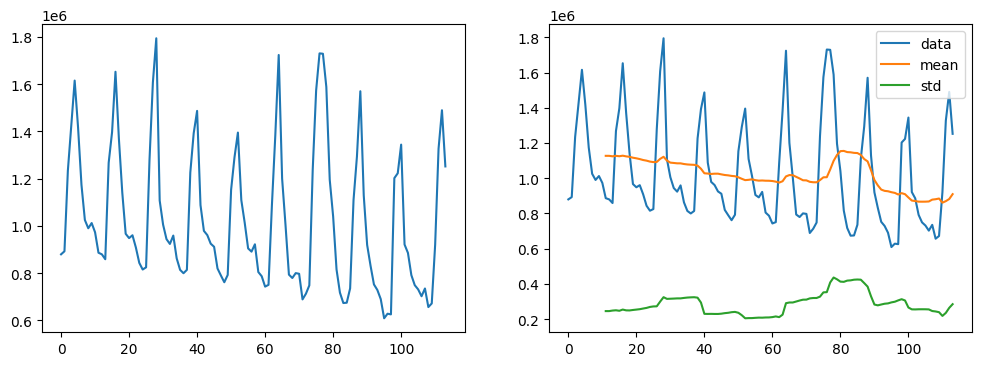

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(station_1['y1'])
check_stationary(station_1, 'y1', ax[1])

#### Validate p, d, q

lag_1

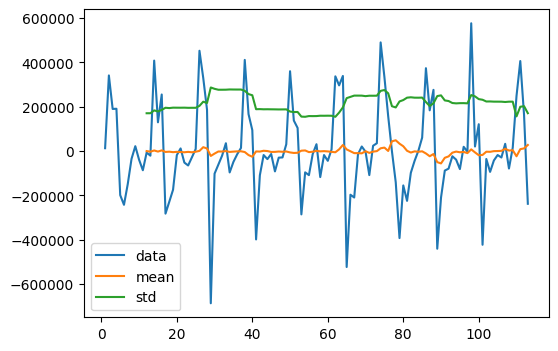

Figure(640x480) Figure(640x480)
Test statistics                 -4.375115
p-value                          0.000328
#lag-used                       11.000000
number of observations used    101.000000
dtype: float64
confidence interval 1%:  -3.4968181663902103
confidence interval 5%:  -2.8906107514600103
confidence interval 10%:  -2.5822770483285953


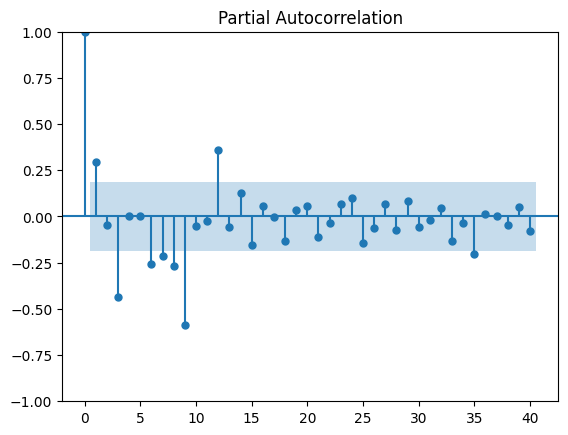

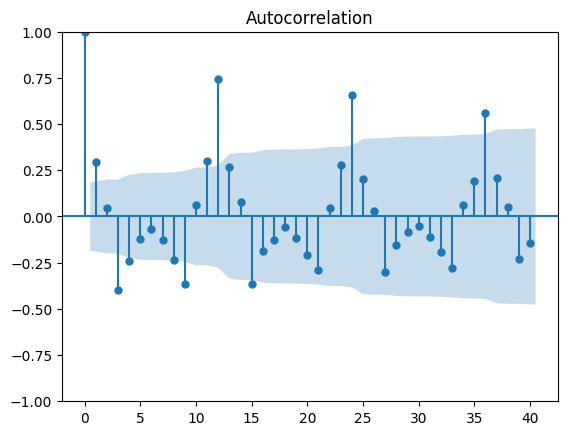

In [81]:
station_1.loc[:, 'diff_1'] = station_1['y1'].diff(1)
check_stationary(station_1, 'diff_1')
test_pdq(station_1, 'diff_1')

seasonal lag

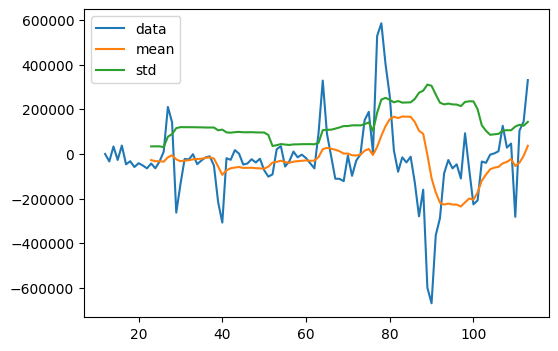

Figure(640x480) Figure(640x480)
Test statistics                -2.266792
p-value                         0.182902
#lag-used                      12.000000
number of observations used    89.000000
dtype: float64
confidence interval 1%:  -3.506057133647011
confidence interval 5%:  -2.8946066061911946
confidence interval 10%:  -2.5844100201994697


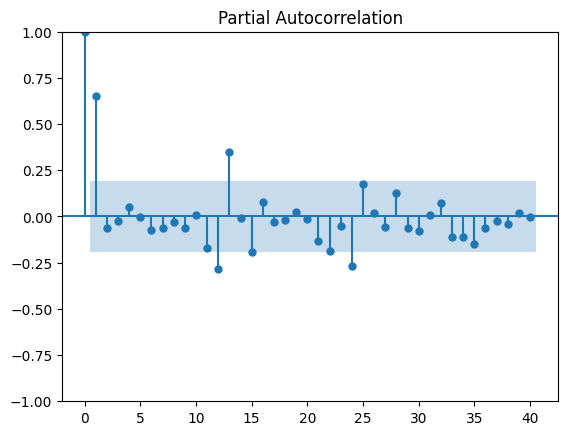

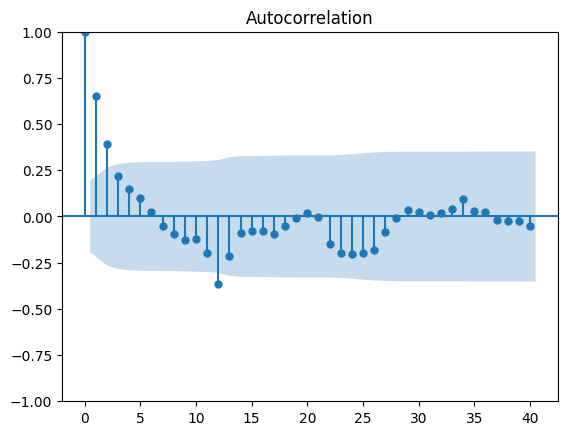

In [87]:
station_1.loc[:, 'diff_12'] = station_1['y1'].diff(12)
check_stationary(station_1, 'diff_12')
test_pdq(station_1, 'diff_12')

#### Prediction

In [107]:
exog = station_1.drop(columns=['y1', 'diff_1', 'diff_12'])

sarima_1 = SARIMAX(station_1['y1'], order=(3, 0, 0), seasonal_order=(0, 1, 0, 12), 
                trend='ct', exog=exog)
sarima_1 = sarima_1.fit()
sarima_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                 y1   No. Observations:                  114
Model:             SARIMAX(3, 0, 0)x(0, 1, 0, 12)   Log Likelihood               -1339.876
Date:                           อา., 22 ก.ย. 2024   AIC                           2719.751
Time:                                    02:38:40   BIC                           2772.251
Sample:                                         0   HQIC                          2741.010
                                            - 114                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -1.473e+04   3.84e+04     -0.384      0.701      -9e+04    6.05e+04
drift        338.9321    516.554      0.656      0.512    -673.496    1351.360
month       6.229e-06   2.85e+04   2.19e-10      1.000   -5.59e+04    5.59e+04
year        -2.08e+04   1.26e+04     -1.655      0.098   -4.54e+04    3827.046
Value       2.742e+04    1.3e+04      2.110      0.035    1951.320    5.29e+04
month_2             0      8.218          0      1.000     -16.107      16.107
month_3             0      8.218          0      1.000     -16.107      16.107
month_4             0      8.218          0      1.000     -16.107      16.107
month_5             0      8.218          0      1.000     -16.107      16.107
month_6     2.649e-10      8.218   3.22e-11      1.000     -16.107      16.107
month_7             0      8.218          0      1.000     -16.108      16.108
month_8             0      8.217          0      1.000     -16.104      16.104
month_9             0      8.233          0      1.000     -16.136      16.136
month_10    2.644e-08    128.681   2.06e-10      1.000    -252.210     252.210
month_11    -7.35e-08    311.707  -2.36e-10      1.000    -610.934     610.934
month_12    5.641e-07   2575.674   2.19e-10      1.000   -5048.229    5048.229
ar.L1          0.7281      0.080      9.146      0.000       0.572       0.884
ar.L2         -0.0895      0.145     -0.618      0.537      -0.373       0.194
ar.L3          0.0341      0.133      0.256      0.798      -0.227       0.296
sigma2      1.523e+10      0.023   6.73e+11      0.000    1.52e+10    1.52e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               188.16
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               3.14   Skew:                             0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.3e+27. Standard errors may be unstable.
"""

In [91]:
exog_pred = pd.DataFrame(columns=exog.columns)

for ind, i in zip(range(6), np.arange(7, 13)):
    exog_pred.loc[ind, f'month_{i}'] = 1
    exog_pred.loc[ind, 'year'] = 10
    
for ind, i in zip(np.arange(6, 12), np.arange(1, 7)):
    if i == 1:
        exog_pred.loc[ind, 'year'] = 11
        continue
    else:
        exog_pred.loc[ind, f'month_{i}'] = 1
        exog_pred.loc[ind, 'year'] = 11  


exog_pred.fillna(0, inplace=True)
exog_pred['Value'] = temp[-12:]['Value'].reset_index(drop=True)

# with pd.option_context('display.max_columns', None):
#     display(exog_pred)

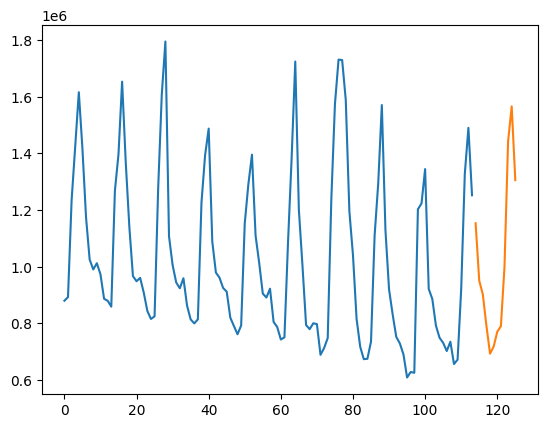

In [108]:
forecast_1 = sarima_1.forecast(steps=12, exog=exog_pred)
plt.plot(range(114), station_1['y1'])
plt.plot(forecast_1)

### Station 2 (y2)

In [41]:
station_2 = df_prep.drop(columns=['y1', 'y3'])
station_2.head()

,y2,month,year,Value,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,52548712.45,1,1,22.400000,0,0,0,0,0,0,0,0,0,0,0
1,52977763.18,2,1,26.733333,1,0,0,0,0,0,0,0,0,0,0
2,62610108.35,3,1,29.500000,0,1,0,0,0,0,0,0,0,0,0
3,58400221.28,4,1,30.333333,0,0,1,0,0,0,0,0,0,0,0
4,65722728.55,5,1,29.900000,0,0,0,1,0,0,0,0,0,0,0


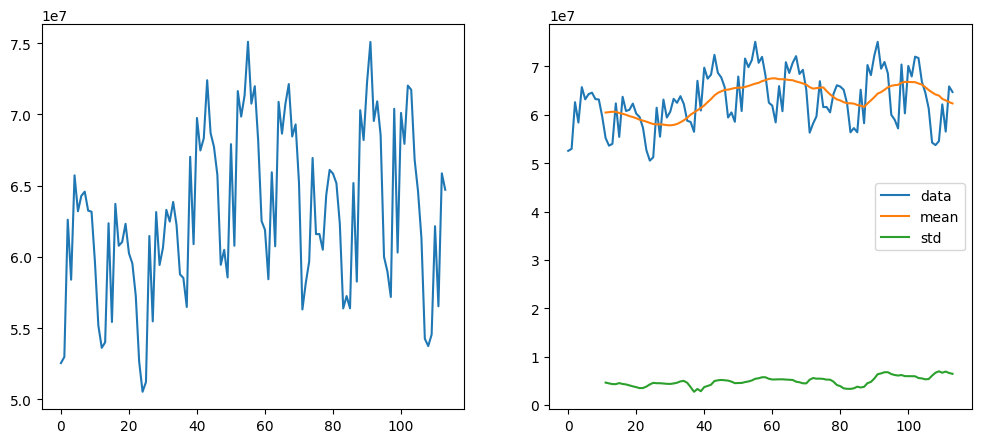

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(station_2['y2'])
check_stationary(station_2, 'y2', ax[1])

#### Validate order
lag 1

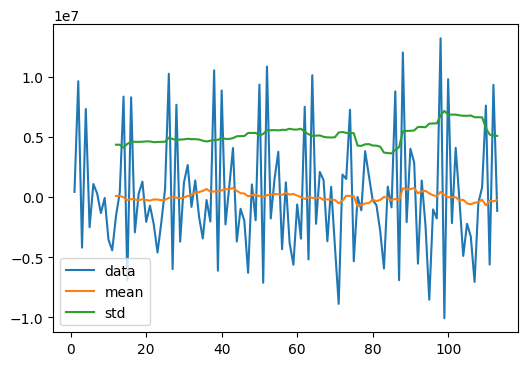

Figure(640x480) Figure(640x480)
Test statistics                 -2.681904
p-value                          0.077222
#lag-used                       11.000000
number of observations used    101.000000
dtype: float64
confidence interval 1%:  -3.4968181663902103
confidence interval 5%:  -2.8906107514600103
confidence interval 10%:  -2.5822770483285953


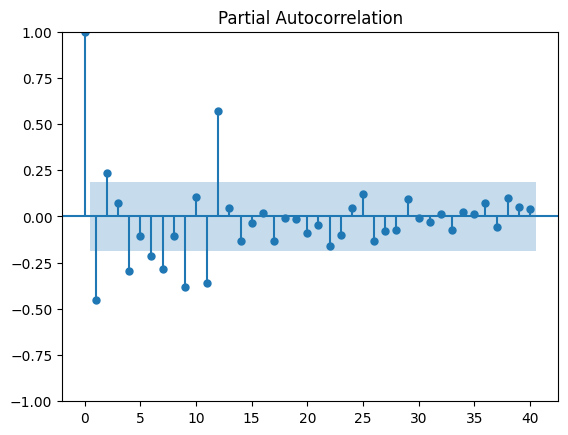

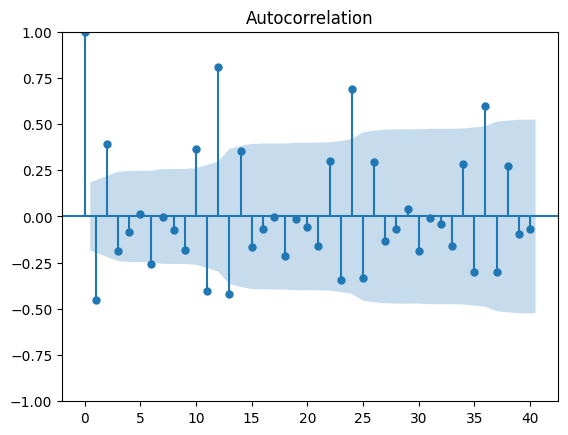

In [109]:
station_2.loc[:, 'diff_1'] = station_2['y2'].diff(1)
check_stationary(station_2, 'diff_1')
test_pdq(station_2, 'diff_1')

seasonal

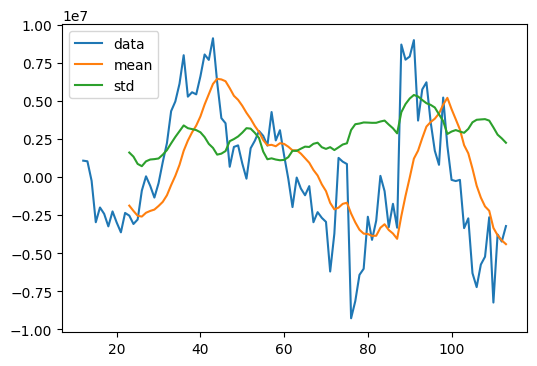

Figure(640x480) Figure(640x480)
Test statistics                -2.544559
p-value                         0.105006
#lag-used                      12.000000
number of observations used    89.000000
dtype: float64
confidence interval 1%:  -3.506057133647011
confidence interval 5%:  -2.8946066061911946
confidence interval 10%:  -2.5844100201994697


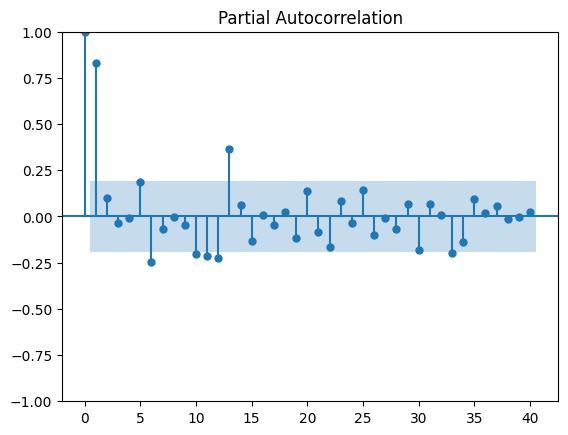

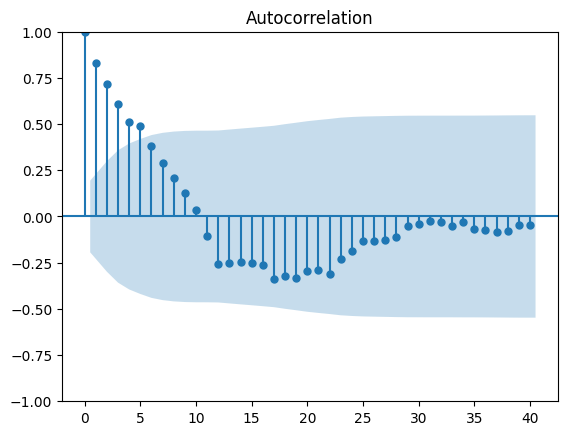

In [110]:
station_2.loc[:, 'diff_12'] = station_2['y2'].diff(12)
check_stationary(station_2, 'diff_12')
test_pdq(station_2, 'diff_12')

#### Model 

In [121]:
sarima_2 = SARIMAX(station_2['y2'], order=(10, 1, 0), seasonal_order=(0, 1, 0, 12), 
                 exog=exog)
sarima_2 = sarima_2.fit()
sarima_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                  y2   No. Observations:                  114
Model:             SARIMAX(10, 1, 0)x(0, 1, 0, 12)   Log Likelihood               -1623.707
Date:                            อา., 22 ก.ย. 2024   AIC                           3297.413
Time:                                     02:42:35   BIC                           3362.791
Sample:                                          0   HQIC                          3323.880
                                             - 114                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
month       3.946e-08    722.289   5.46e-11      1.000   -1415.660    1415.660
year       -1.357e-10     81.516  -1.66e-12      1.000    -159.768     159.768
Value       4.378e+05   2.01e+05      2.174      0.030     4.3e+04    8.33e+05
month_2    -3.171e-11     35.296  -8.98e-13      1.000     -69.180      69.180
month_3    -5.022e-10        nan        nan        nan         nan         nan
month_4    -2.928e-10     23.325  -1.26e-11      1.000     -45.716      45.716
month_5    -7.661e-11    115.245  -6.65e-13      1.000    -225.876     225.876
month_6     1.786e-10     18.832   9.48e-12      1.000     -36.911      36.911
month_7     1.281e-09     73.255   1.75e-11      1.000    -143.577     143.577
month_8    -4.853e-10     12.845  -3.78e-11      1.000     -25.175      25.175
month_9      7.27e-11    110.633   6.57e-13      1.000    -216.836     216.836
month_10    8.011e-11    124.310   6.44e-13      1.000    -243.644     243.644
month_11     1.22e-09    191.844   6.36e-12      1.000    -376.008     376.008
month_12    2.374e-09    158.272    1.5e-11      1.000    -310.208     310.208
ar.L1         -0.0427      0.091     -0.469      0.639      -0.221       0.136
ar.L2          0.0226      0.126      0.179      0.858      -0.225       0.270
ar.L3          0.0226      0.058      0.389      0.697      -0.091       0.136
ar.L4         -0.0272      0.074     -0.369      0.712      -0.172       0.117
ar.L5          0.0464      0.069      0.676      0.499      -0.088       0.181
ar.L6          0.0066      0.161      0.041      0.967      -0.309       0.322
ar.L7         -0.0161      0.111     -0.145      0.885      -0.234       0.202
ar.L8         -0.0101      0.095     -0.106      0.915      -0.197       0.177
ar.L9          0.0220      0.115      0.192      0.847      -0.203       0.247
ar.L10         0.0304      0.056      0.538      0.591      -0.080       0.141
sigma2      5.334e+12      0.009   6.03e+14      0.000    5.33e+12    5.33e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.75   Jarque-Bera (JB):               296.75
Prob(Q):                              0.38   Prob(JB):                         0.00
Heteroskedasticity (H):               6.13   Skew:                             0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.23e+30. Standard errors may be unstable.
"""

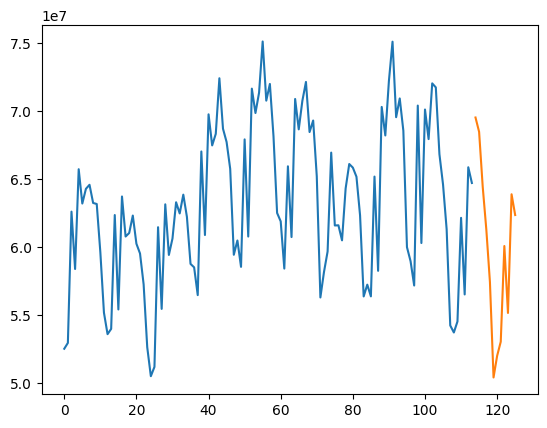

In [122]:
forecast_2 = sarima_2.forecast(steps=12, exog=exog_pred)
plt.plot(range(114), station_2['y2'])
plt.plot(forecast_2)

### Station 3

In [123]:
station_3 = df_prep.drop(columns=['y1', 'y2'])
station_3.head()

,y3,month,year,Value,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,1145963,1,1,22.400000,0,0,0,0,0,0,0,0,0,0,0
1,1029008,2,1,26.733333,1,0,0,0,0,0,0,0,0,0,0
2,1195365,3,1,29.500000,0,1,0,0,0,0,0,0,0,0,0
3,1370666,4,1,30.333333,0,0,1,0,0,0,0,0,0,0,0
4,1685763,5,1,29.900000,0,0,0,1,0,0,0,0,0,0,0


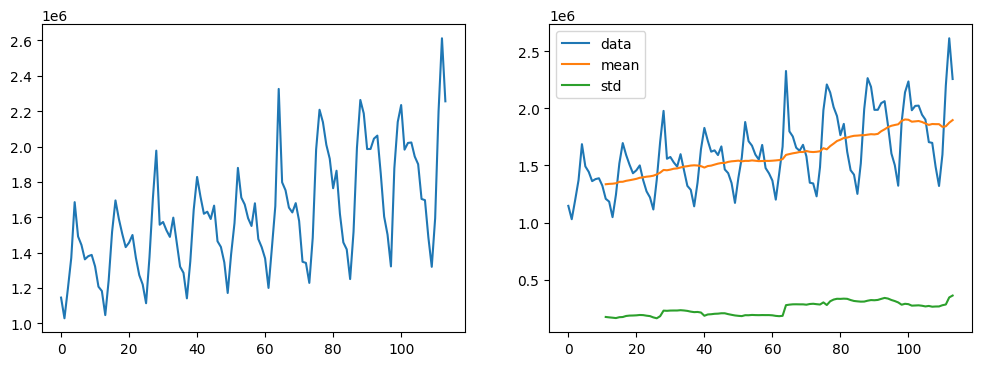

In [124]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(station_3['y3'])
check_stationary(station_3, 'y3', ax[1])

#### Validate order

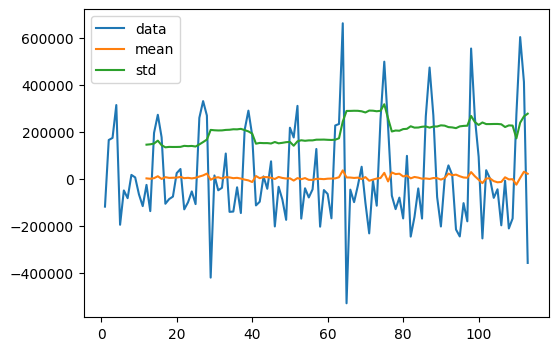

Figure(640x480) Figure(640x480)
Test statistics               -1.513157e+01
p-value                        7.219264e-28
#lag-used                      1.000000e+01
number of observations used    1.020000e+02
dtype: float64
confidence interval 1%:  -3.4961490537199116
confidence interval 5%:  -2.8903209639580556
confidence interval 10%:  -2.5821223452518263


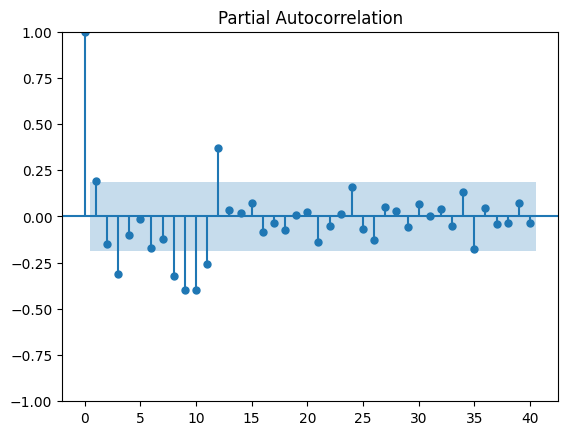

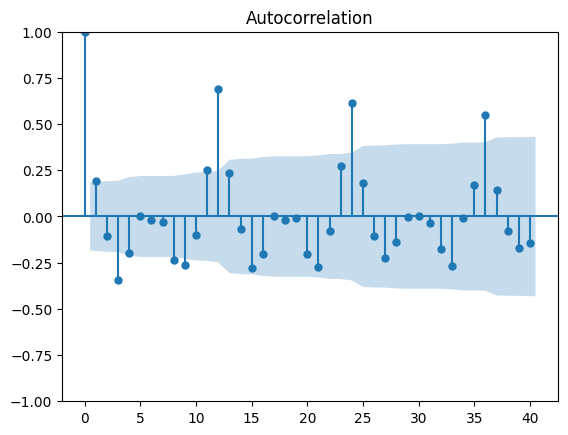

In [125]:
station_3.loc[:, 'diff_1'] = station_3['y3'].diff(1)
check_stationary(station_3, 'diff_1')
test_pdq(station_3, 'diff_1')

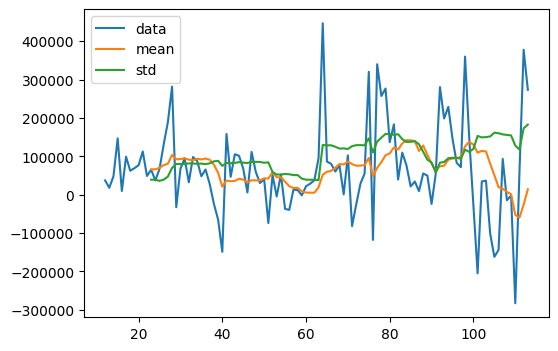

Figure(640x480) Figure(640x480)
Test statistics                -1.598966
p-value                         0.484113
#lag-used                      13.000000
number of observations used    88.000000
dtype: float64
confidence interval 1%:  -3.506944401824286
confidence interval 5%:  -2.894989819214876
confidence interval 10%:  -2.584614550619835


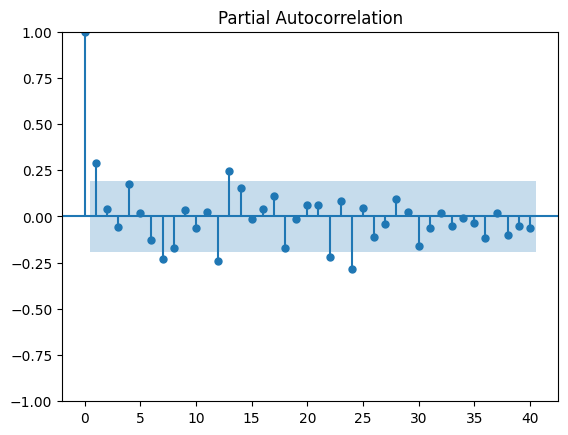

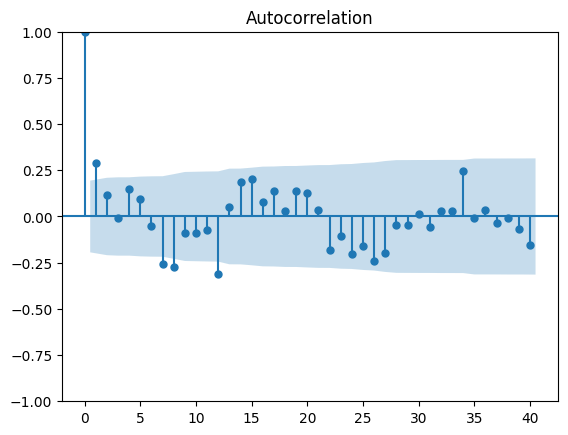

In [126]:
station_3.loc[:, 'diff_12'] = station_3['y3'].diff(12)
check_stationary(station_3, 'diff_12')
test_pdq(station_3, 'diff_12')

In [129]:
sarima_3 = SARIMAX(station_3['y3'], order=(10, 0, 0), seasonal_order=(0, 1, 0, 12), 
                 trend='ct', exog=exog)
sarima_3 = sarima_3.fit()
sarima_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                  y3   No. Observations:                  114
Model:             SARIMAX(10, 0, 0)x(0, 1, 0, 12)   Log Likelihood               -1322.790
Date:                            อา., 22 ก.ย. 2024   AIC                           2699.579
Time:                                     02:44:22   BIC                           2770.454
Sample:                                          0   HQIC                          2728.279
                                             - 114                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -1.765e+04   2.13e+04     -0.827      0.408   -5.95e+04    2.42e+04
drift        402.8966    445.675      0.904      0.366    -470.610    1276.403
month       1.137e-05   4.87e+04   2.34e-10      1.000   -9.54e+04    9.54e+04
year        6.961e+04   1.71e+04      4.067      0.000    3.61e+04    1.03e+05
Value       2.043e+04   9722.228      2.102      0.036    1376.463    3.95e+04
month_2    -9.141e-12   1.31e+05  -6.99e-17      1.000   -2.56e+05    2.56e+05
month_3     7.024e-08   6.24e+04   1.13e-12      1.000   -1.22e+05    1.22e+05
month_4     1.113e-07   1.36e+05   8.18e-13      1.000   -2.67e+05    2.67e+05
month_5    -1.515e-07   4.34e+05  -3.49e-13      1.000   -8.51e+05    8.51e+05
month_6    -2.417e-07   2.62e+05  -9.21e-13      1.000   -5.14e+05    5.14e+05
month_7    -9.068e-08   2.75e+05  -3.29e-13      1.000    -5.4e+05     5.4e+05
month_8     1.251e-08   6.46e+05   1.94e-14      1.000   -1.27e+06    1.27e+06
month_9     1.452e-07   2.42e+05   6.01e-13      1.000   -4.74e+05    4.74e+05
month_10    2.652e-07   3.43e+05   7.74e-13      1.000   -6.71e+05    6.71e+05
month_11    5.747e-07   2.65e+05   2.17e-12      1.000   -5.19e+05    5.19e+05
month_12    2.623e-07    2.6e+05   1.01e-12      1.000   -5.09e+05    5.09e+05
ar.L1          0.1780      0.111      1.602      0.109      -0.040       0.396
ar.L2          0.0457      0.104      0.438      0.661      -0.159       0.250
ar.L3         -0.0962      0.126     -0.766      0.444      -0.342       0.150
ar.L4          0.2101      0.141      1.491      0.136      -0.066       0.486
ar.L5          0.0069      0.134      0.051      0.959      -0.256       0.270
ar.L6          0.0302      0.116      0.260      0.795      -0.198       0.258
ar.L7         -0.1382      0.202     -0.686      0.493      -0.533       0.257
ar.L8         -0.1979      0.173     -1.141      0.254      -0.538       0.142
ar.L9          0.0895      0.150      0.599      0.549      -0.204       0.383
ar.L10         0.0696      0.149      0.469      0.639      -0.222       0.361
sigma2      1.059e+10     28.102   3.77e+08      0.000    1.06e+10    1.06e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):                22.87
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):               2.01   Skew:                             0.80
Prob(H) (two-sided):                  0.05   Kurtosis:                         4.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.57e+25. Standard errors may be unstable.
"""

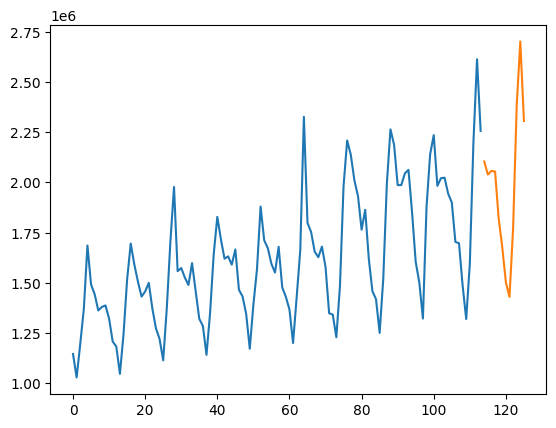

In [140]:
forecast_3 = sarima_3.forecast(steps=12, exog=exog_pred)
plt.plot(range(114), station_3['y3'])
plt.plot(forecast_3)

## Submission

In [141]:
submission = pd.read_csv('submit/sample_submission.csv', index_col='id')
result = pd.concat([forecast_1, forecast_2, forecast_3])

submission['Predict'] = result.values
submission.to_csv('submit/submission_3.csv')